In [139]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt

# modelling
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# import a bunch of clustering models
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

In [114]:
df = pd.read_csv('Use this dataset/uswtdb_v5_0_20220427_rename.csv',
                 index_col=0)

/var/folders/nv/vxq64h_j3ydccspj69p0_4_c0000gn/T/ipykernel_34359/281542650.py:1: DtypeWarning: Columns (5,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Use this dataset/uswtdb_v5_0_20220427_rename.csv',


In [115]:
df.shape

(80103, 123)

In [116]:
df.head()

,Combined Heat And\nPower Plant,Nuclear Unit Id,Plant Name,Operator Name,Operator Id,Plant State,Census Region,NERC Region,Reserved,NAICS Code,EIA Sector Number,Sector Name,Reported\nPrime Mover,Reported\nFuel Type Code,AER\nFuel Type Code,Balancing\nAuthority Code,Respondent\nFrequency,Physical\nUnit Label,Quantity\nJanuary,Quantity\nFebruary,Quantity\nMarch,Quantity\nApril,Quantity\nMay,Quantity\nJune,Quantity\nJuly,Quantity\nAugust,Quantity\nSeptember,Quantity\nOctober,Quantity\nNovember,Quantity\nDecember,Elec_Quantity\nJanuary,Elec_Quantity\nFebruary,Elec_Quantity\nMarch,Elec_Quantity\nApril,Elec_Quantity\nMay,Elec_Quantity\nJune,Elec_Quantity\nJuly,Elec_Quantity\nAugust,Elec_Quantity\nSeptember,Elec_Quantity\nOctober,Elec_Quantity\nNovember,Elec_Quantity\nDecember,MMBtuPer_Unit\nJanuary,MMBtuPer_Unit\nFebruary,MMBtuPer_Unit\nMarch,MMBtuPer_Unit\nApril,MMBtuPer_Unit\nMay,MMBtuPer_Unit\nJune,MMBtuPer_Unit\nJuly,MMBtuPer_Unit\nAugust,MMBtuPer_Unit\nSeptember,MMBtuPer_Unit\nOctober,MMBtuPer_Unit\nNovember,MMBtuPer_Unit\nDecember,Tot_MMBtu\nJanuary,Tot_MMBtu\nFebruary,Tot_MMBtu\nMarch,Tot_MMBtu\nApril,Tot_MMBtu\nMay,Tot_MMBtu\nJune,Tot_MMBtu\nJuly,Tot_MMBtu\nAugust,Tot_MMBtu\nSeptember,Tot_MMBtu\nOctober,Tot_MMBtu\nNovember,Tot_MMBtu\nDecember,Elec_MMBtu\nJanuary,Elec_MMBtu\nFebruary,Elec_MMBtu\nMarch,Elec_MMBtu\nApril,Elec_MMBtu\nMay,Elec_MMBtu\nJune,Elec_MMBtu\nJuly,Elec_MMBtu\nAugust,Elec_MMBtu\nSeptember,Elec_MMBtu\nOctober,Elec_MMBtu\nNovember,Elec_MMBtu\nDecember,Netgen\nJanuary,Netgen\nFebruary,Netgen\nMarch,Netgen\nApril,Netgen\nMay,Netgen\nJune,Netgen\nJuly,Netgen\nAugust,Netgen\nSeptember,Netgen\nOctober,Netgen\nNovember,Netgen\nDecember,Total Fuel Consumption\nQuantity,Electric Fuel Consumption\nQuantity,Total Fuel Consumption\nMMBtu,Elec Fuel Consumption\nMMBtu,Net Generation\n(Megawatthours),YEAR,case_id,faa_digital_obstacle_id,faa_obstruction_evaluation_id,usgs_id,eia_id,state,county,state_county_id,project_name,operational_year,project_turbine_num,cumulative_capacity (MW),manufacturer,model_name,turbine_capacity (KW),hub_height (m),rotor_diameter (m),rotor_swept area (m2),max_height (m),retrofit (y/n),retrofit_year,attribute_confidence_level (1/2/3),location_confidence_level (1/2/3),location_verification_date,image_source,xlong,ylat
Plant Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,N,.,Sand Point,"TDX Sand Point Generating, LLC",63560,AK,PACN,NaN,NaN,22,1,Electric Utility,IC,DFO,DFO,NaN,A,barrels,466,514,556,535,277,372,363,524,679,674,526,585,466,514,556,535,277,372,363,524,679,674,526,585,5.846,5.846,5.846,5.846,5.846,5.846,5.846,5.846,5.846,5.846,5.846,5.846,2724,3005,3250,3128,1619,2175,2122,3063,3969,3940,3075,3420,2724,3005,3250,3128,1619,2175,2122,3063,3969,3940,3075,3420,208.841,231.25,250.099,240.409,124.504,167.13,163.329,235.54,305.071,303.095,236.655,263.077,6071,6071,35490,35490,2729.0,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,N,.,Sand Point,"TDX Sand Point Generating, LLC",63560,AK,PACN,NaN,NaN,22,1,Electric Utility,WT,WND,WND,NaN,A,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,103,78,97,77,91,94,111,113,115,117,66,122,103,78,97,77,91,94,111,113,115,117,66,122,11.609,8.836,11.011,8.745,10.329,10.673,12.572,12.738,13.051,13.182,7.49,13.764,0,0,1184,1184,134.0,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N,.,Bankhead Dam,Alabama Power Co,195,AL,ESC,SERC,NaN,22,1,Electric Utility,HY,WAT,HYC,SOCO,A,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,193267,160812,154227,136040,168541,181467,161573,152459,125050,128322,150396,193250,193267,160812,154227,136040,168541,181467,161573,152459,125050,128322,150396,193250,21852.91,18183.22,17438.642,15382.198,19057.047,20518.616,18269.278,17238.672,14139.512,14509.501,17005.425,21850

In [117]:
# only filter wind_turbine plants based on WT or WS
wind_df = df[df['Reported\nPrime Mover'].str.contains('WT|WS')]
# reset index of wind_df and put it as a column
wind_df.reset_index(inplace=True)

In [118]:
wind_df.head()

,Plant Id,Combined Heat And\nPower Plant,Nuclear Unit Id,Plant Name,Operator Name,Operator Id,Plant State,Census Region,NERC Region,Reserved,NAICS Code,EIA Sector Number,Sector Name,Reported\nPrime Mover,Reported\nFuel Type Code,AER\nFuel Type Code,Balancing\nAuthority Code,Respondent\nFrequency,Physical\nUnit Label,Quantity\nJanuary,Quantity\nFebruary,Quantity\nMarch,Quantity\nApril,Quantity\nMay,Quantity\nJune,Quantity\nJuly,Quantity\nAugust,Quantity\nSeptember,Quantity\nOctober,Quantity\nNovember,Quantity\nDecember,Elec_Quantity\nJanuary,Elec_Quantity\nFebruary,Elec_Quantity\nMarch,Elec_Quantity\nApril,Elec_Quantity\nMay,Elec_Quantity\nJune,Elec_Quantity\nJuly,Elec_Quantity\nAugust,Elec_Quantity\nSeptember,Elec_Quantity\nOctober,Elec_Quantity\nNovember,Elec_Quantity\nDecember,MMBtuPer_Unit\nJanuary,MMBtuPer_Unit\nFebruary,MMBtuPer_Unit\nMarch,MMBtuPer_Unit\nApril,MMBtuPer_Unit\nMay,MMBtuPer_Unit\nJune,MMBtuPer_Unit\nJuly,MMBtuPer_Unit\nAugust,MMBtuPer_Unit\nSeptember,MMBtuPer_Unit\nOctober,MMBtuPer_Unit\nNovember,MMBtuPer_Unit\nDecember,Tot_MMBtu\nJanuary,Tot_MMBtu\nFebruary,Tot_MMBtu\nMarch,Tot_MMBtu\nApril,Tot_MMBtu\nMay,Tot_MMBtu\nJune,Tot_MMBtu\nJuly,Tot_MMBtu\nAugust,Tot_MMBtu\nSeptember,Tot_MMBtu\nOctober,Tot_MMBtu\nNovember,Tot_MMBtu\nDecember,Elec_MMBtu\nJanuary,Elec_MMBtu\nFebruary,Elec_MMBtu\nMarch,Elec_MMBtu\nApril,Elec_MMBtu\nMay,Elec_MMBtu\nJune,Elec_MMBtu\nJuly,Elec_MMBtu\nAugust,Elec_MMBtu\nSeptember,Elec_MMBtu\nOctober,Elec_MMBtu\nNovember,Elec_MMBtu\nDecember,Netgen\nJanuary,Netgen\nFebruary,Netgen\nMarch,Netgen\nApril,Netgen\nMay,Netgen\nJune,Netgen\nJuly,Netgen\nAugust,Netgen\nSeptember,Netgen\nOctober,Netgen\nNovember,Netgen\nDecember,Total Fuel Consumption\nQuantity,Electric Fuel Consumption\nQuantity,Total Fuel Consumption\nMMBtu,Elec Fuel Consumption\nMMBtu,Net Generation\n(Megawatthours),YEAR,case_id,faa_digital_obstacle_id,faa_obstruction_evaluation_id,usgs_id,eia_id,state,county,state_county_id,project_name,operational_year,project_turbine_num,cumulative_capacity (MW),manufacturer,model_name,turbine_capacity (KW),hub_height (m),rotor_diameter (m),rotor_swept area (m2),max_height (m),retrofit (y/n),retrofit_year,attribute_confidence_level (1/2/3),location_confidence_level (1/2/3),location_verification_date,image_source,xlong,ylat
0,1,N,.,Sand Point,"TDX Sand Point Generating, LLC",63560,AK,PACN,NaN,NaN,22,1,Electric Utility,WT,WND,WND,NaN,A,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,103,78,97,77,91,94,111,113,115,117,66,122,103,78,97,77,91,94,111,113,115,117,66,122,11.609,8.836,11.011,8.745,10.329,10.673,12.572,12.738,13.051,13.182,7.49,13.764,0,0,1184,1184,134.0,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,90,N,.,Snake River,Nome Joint Utility Systems,13642,AK,PACN,NaN,NaN,22,1,Electric Utility,WT,WND,WND,NaN,A,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1632,1242,1548,1229,1452,1500,1767,1791,1835,1853,1053,1935,1632,1242,1548,1229,1452,1500,1767,1791,1835,1853,1053,1935,184.495,140.449,175.033,139.011,164.189,169.653,199.846,202.478,207.46,209.538,119.062,218.786,0,0,18837,18837,2130.0,2021,3032513.0,02-020068,2009-WTW-1520-OE,1900.0,90.0,AK,Nome Census Area,2180.0,Nome,2008.0,18.0,0.9,Entegrity,EW50,50.0,31.1,15.0,176.71,38.6,0.0,NaN,3.0,3.0,9/30/2019,Digital Globe,-165.426483,64.571999
2,90,N,.,Snake River,Nome Joint Utility Systems,13642,AK,PACN,NaN,NaN,22,1,Electric Utility,WT,WND,WND,NaN,A,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1632,1242,1548,1229,1452,1500,1767,1791,1835,1853,1053,1935,1632,1242,1548,1229,1452,1500,1767,1791,1835,1853,1053,1935,184.495,140.449,175.033,139.011,164.189,169.653,199.846,202.478,207.46,209.538,119.062,218.786,0,0,18837,18837,2130.0,2021,3032511.0,02-020066,2009-WTW-1518-OE,1898.0,90.0,AK,Nome Census Area,2180.0,Nome,2008.0,18.0,0.9,Entegrity,EW50,50.0,31.1,15.0,176.71,38.6,0.0,NaN,3.0,3.0,9/30

## Missing Model Specs 

In [119]:
missing_values = wind_df[wind_df.model_name.isnull()]['Plant Id'].nunique()

In [120]:
missing_values = wind_df[wind_df.model_name.isnull()]['Plant Id'].nunique()

In [121]:
total_plants = wind_df['Plant Id'].nunique()

In [122]:
print(f'we are dropping {missing_values/total_plants*100:.2f}% of the data')

we are dropping 10.01% of the data


In [123]:
# drop null values
wind_df = wind_df[wind_df.model_name.isnull()]

## Model

In [124]:
# are the columns the same?
a = wind_df['Elec Fuel Consumption\nMMBtu'] == wind_df['Total Fuel Consumption\nMMBtu']
# assert all of the a.value_counts() are true
assert all(a.value_counts())==True, 'The columns are not the same'

In [125]:
features = ['Plant Id', 'Reported\nPrime Mover', 'Plant State', 'Net Generation\n(Megawatthours)', 'Elec Fuel Consumption\nMMBtu','cumulative_capacity (MW)']

In [126]:
model_df = wind_df[features]

In [127]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1036 entries, 0 to 64538
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Plant Id                        1036 non-null   int64  
 1   Reported
Prime Mover            1036 non-null   object 
 2   Plant State                     1036 non-null   object 
 3   Net Generation
(Megawatthours)  1036 non-null   float64
 4   Elec Fuel Consumption
MMBtu     1036 non-null   int64  
 5   cumulative_capacity (MW)        914 non-null    float64
dtypes: float64(2), int64(2), object(2)
memory usage: 56.7+ KB


In [128]:
# drop missing values
model_df.dropna(inplace=True)

/var/folders/nv/vxq64h_j3ydccspj69p0_4_c0000gn/T/ipykernel_34359/412540977.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.dropna(inplace=True)


In [129]:
model_df['Plant Id'].value_counts().sort_values(ascending=False).head()

10597    215
50532    215
54909    190
10005    161
50821    118
Name: Plant Id, dtype: int64

In [132]:
# remove duplicates
model_df.drop_duplicates(inplace=True)

/var/folders/nv/vxq64h_j3ydccspj69p0_4_c0000gn/T/ipykernel_34359/1276753530.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.drop_duplicates(inplace=True)


## Numerical Features

In [133]:
model_df.describe()

,Plant Id,Net Generation\n(Megawatthours),Elec Fuel Consumption\nMMBtu,cumulative_capacity (MW)
count,7.000000,7.000000,7.000000,7.000000
mean,40835.428571,38773.714286,342914.714286,29.421429
std,20935.446790,27611.582290,244196.731021,25.313860
min,10005.000000,14693.000000,129944.000000,9.000000
25%,30564.500000,21314.500000,188505.500000,17.015000
50%,50821.000000,27921.000000,246934.000000,22.170000
75%,54492.000000,45668.500000,403892.500000,28.000000
max,54909.000000,94836.000000,838729.000000,84.750000


/var/folders/nv/vxq64h_j3ydccspj69p0_4_c0000gn/T/ipykernel_34359/923338878.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = model_df.corr()


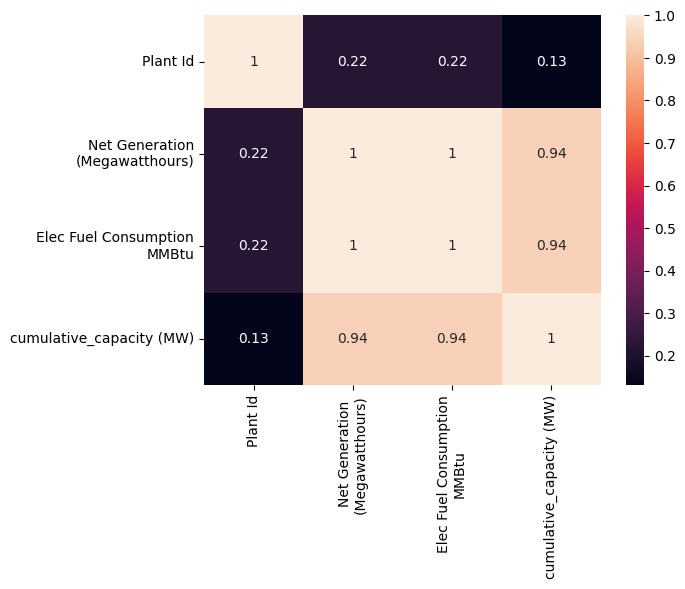

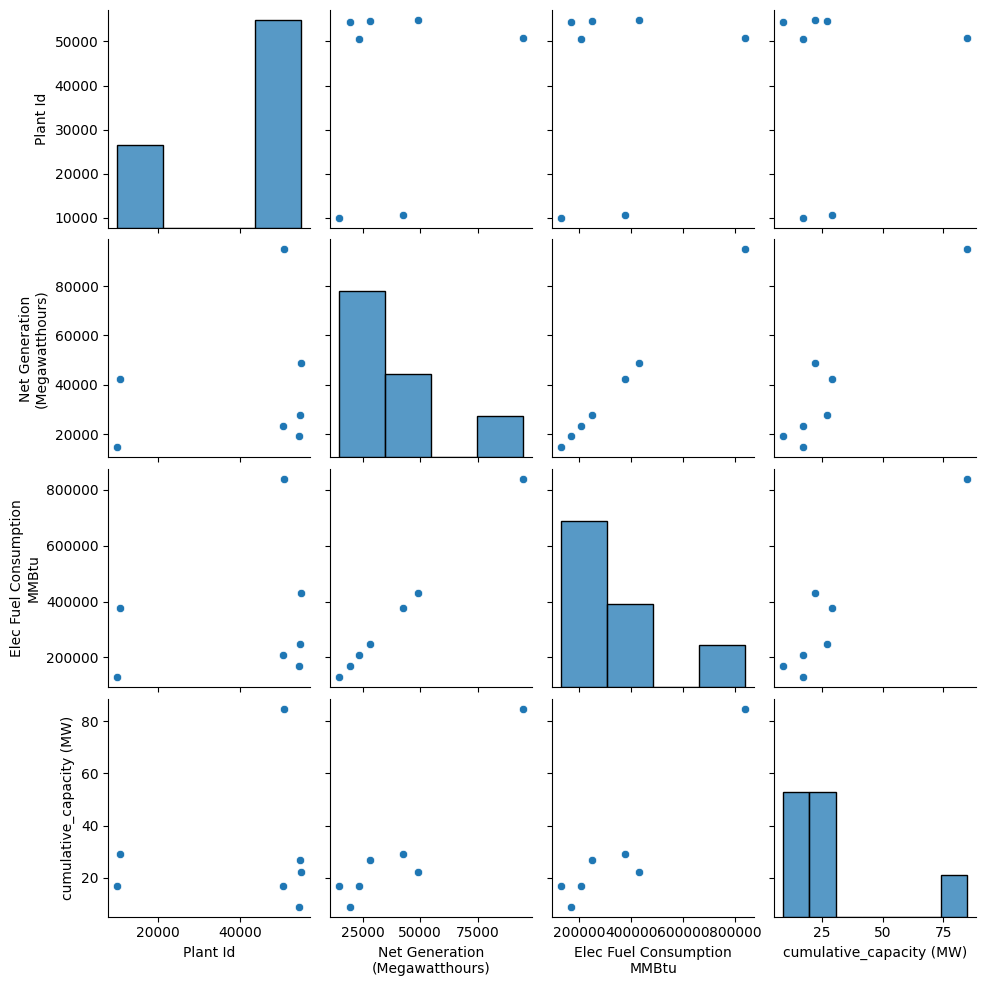

In [134]:
# plot a correlation matrix
import seaborn as sns
corr = model_df.corr()
sns.heatmap(corr, annot=True)

# plot a pairplot
sns.pairplot(model_df)

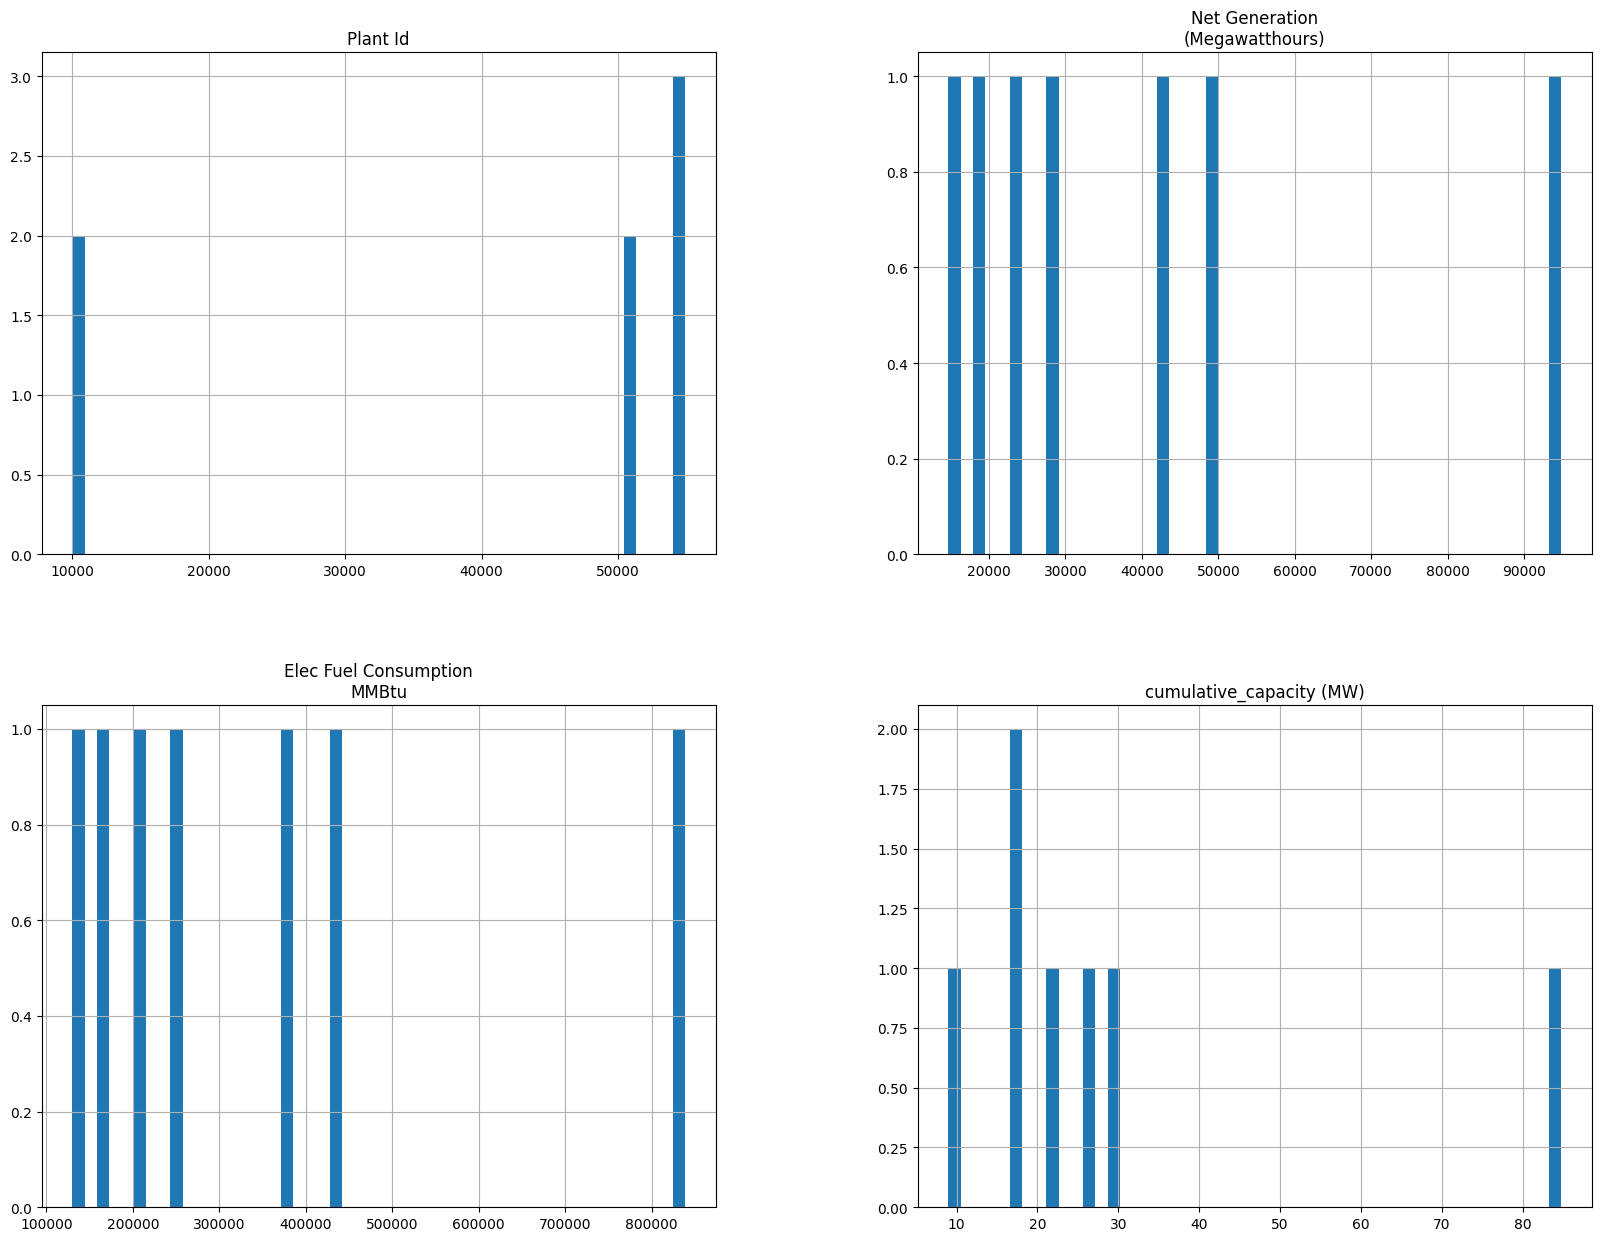

In [135]:
# plot histogram for each numerical feature
model_df.hist(bins=50, figsize=(20,15))
plt.show()

## Categorical Features

In [136]:
# for WT or WS, show the average net generation
wind_df.groupby('Reported\nPrime Mover')['Net Generation\n(Megawatthours)'].mean()

# we have removed all the WS plants previously

Reported\nPrime Mover
WT    41354.821181
Name: Net Generation\n(Megawatthours), dtype: float64

## Pipeline

In [ ]:
X = 

In [ ]:
# setup the ordinal features
# ordinal_features = ['education']
# order = [['basic.4y', 'basic.6y','basic.9y', 'high.school','professional.course','university.degree']]

# setup the numerical and categorical features
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
# for idp_var in ordinal_features:
    # while idp_var in categorical_features:
        # categorical_features.remove(idp_var)

In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ('tnf1',StandardScaler(),numerical_features),
    # ('tnf2',OrdinalEncoder(categories=order),ordinal_features),
    ('tnf3',OneHotEncoder(),categorical_features)
# ])
], remainder='passthrough')

In [140]:
models = [
        ('KM', KMeans()),
        ('DB', DBSCAN()),
        ('AC', AgglomerativeClustering()),
        ('BIR', Birch()),
        ('MBKM', MiniBatchKMeans()),
        ('MS', MeanShift()),
        ('OPT', OPTICS()),
        ('SC', SpectralClustering()),
        ('AP', AffinityPropagation())
        ]

In [141]:
# introduce different clustering scoring metrics
scoring = ['adjusted_rand_score', 'adjusted_mutual_info_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'fowlkes_mallows_score']

In [ ]:
names = []
scorer = []
for name, model in models:
    for score in scoring:
        
        
        names.append(name)
        scorer.append(score)

        pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', model)])
        
        if name == 'KM':
            params = {'classifier__n_clusters': [2,3,4,5,6,7,8,9,10]}
        elif name == 'DB':
            params = {'classifier__eps': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]}
        elif name == 'AC':
            params = {'classifier__n_clusters': [2,3,4,5,6,7,8,9,10]}
        elif name == 'BIR':
            params = {'classifier__n_clusters': [2,3,4,5,6,7,8,9,10]}
        elif name == 'MBKM':
            params = {'classifier__n_clusters': [2,3,4,5,6,7,8,9,10]}
        elif name == 'MS':
            params = {'classifier__bandwidth': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]}
        elif name == 'OPT':
            params = {'classifier__min_samples': [2,3,4,5,6,7,8,9,10]}
        elif name == 'SC':
            params = {'classifier__n_clusters': [2,3,4,5,6,7,8,9,10]}
        elif name == 'AP':
            params = {'classifier__damping': [0.5,0.6,0.7,0.8,0.9,1.0]}

        print(f'running {name} with {model}')

        grid2 = GridSearchCV(pipeline, params, cv=5, scoring = score)
        grid2.fit(X_train, y_train==1)
        y_pred = grid2.predict(X_test)